Please upload your dataset file:


Saving synthetic_preterm_birth_data.csv to synthetic_preterm_birth_data (2).csv

Dataset loaded successfully!
Total samples: 500
Preterm cases: 251
Full-term cases: 249

Training model...

=== Model Evaluation Metrics ===
Accuracy: 89.11%
AUC-ROC Score: 97.65%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        51
           1       0.85      0.94      0.90        50

    accuracy                           0.89       101
   macro avg       0.89      0.89      0.89       101
weighted avg       0.90      0.89      0.89       101


Confusion Matrix:
[[43  8]
 [ 3 47]]

Specificity (True Negative Rate): 84.31%
Sensitivity (Recall/True Positive Rate): 94.00%


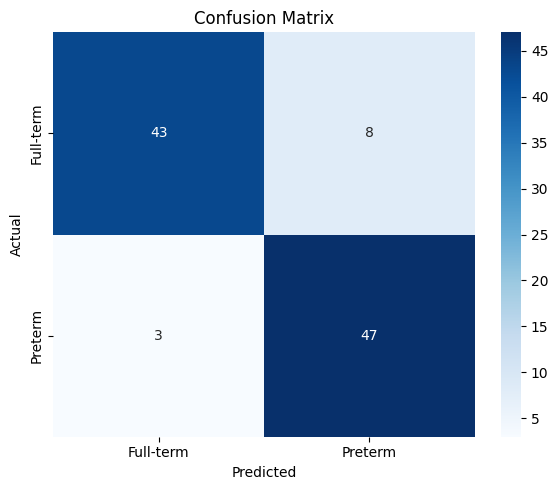

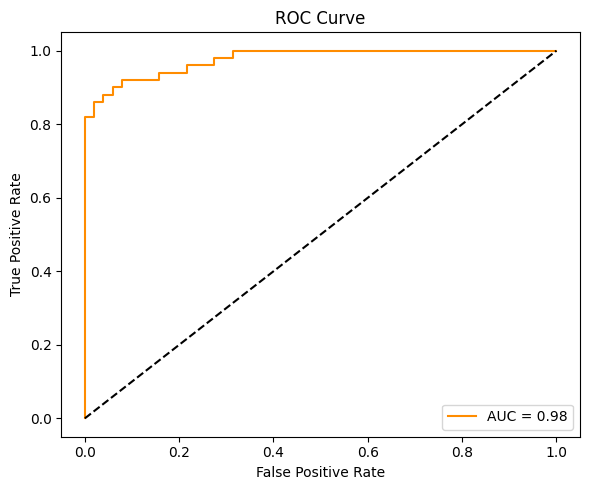

<ipython-input-3-b54877812d84>:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


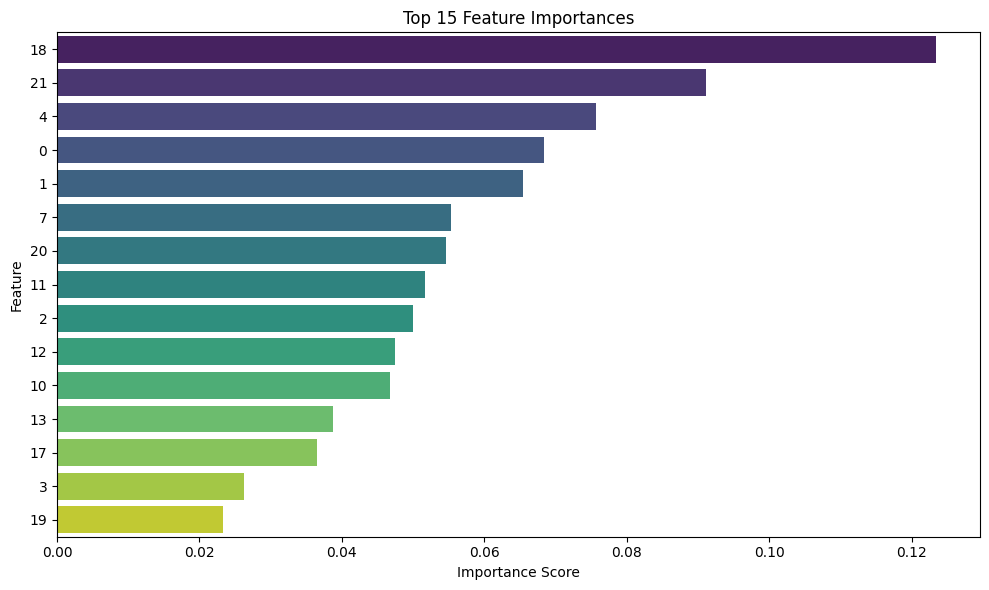

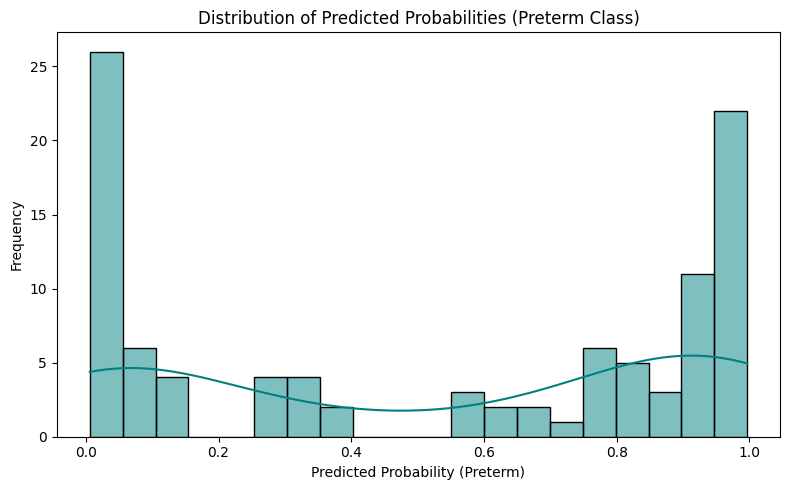


PREDICTION SYSTEM READY
Enter any index (0 to 499) to predict, or 'q' to quit


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(



PREDICTION FOR SAMPLE #200
Actual Outcome: Preterm
Predicted Outcome: Preterm
Prediction Confidence: 91.9%

Probability Breakdown:
- Full-term: 8.1%
- Preterm: 91.9%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(



PREDICTION FOR SAMPLE #1
Actual Outcome: Full-term
Predicted Outcome: Full-term
Prediction Confidence: 92.1%

Probability Breakdown:
- Full-term: 92.1%
- Preterm: 7.9%


In [ ]:
# Part 1: Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)

from imblearn.over_sampling import SMOTE

# For uploading dataset
from google.colab import files

print("Please upload your dataset file:")
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
data = pd.read_csv(file_path)

print("\nDataset loaded successfully!")
print("Total samples:", len(data))
print("Preterm cases:", sum(data['Label']))
print("Full-term cases:", len(data) - sum(data['Label']))

# Part 2: Data Preparation
# Features and target
X = data.drop(['Label'], axis=1)   # Corrected here ✅
y = data['Label']

# Convert to numeric and impute missing values
X = X.apply(pd.to_numeric, errors='coerce')

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Part 3: Model Training
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

print("\nTraining model...")
model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    scale_pos_weight=len(y_res[y_res==0])/len(y_res[y_res==1]),
    random_state=42
)
model.fit(X_train, y_train)

# Part 4: Model Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n=== Model Evaluation Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSpecificity (True Negative Rate): {specificity:.2%}")
print(f"Sensitivity (Recall/True Positive Rate): {sensitivity:.2%}")

# Part 5: Data Visualization
# Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Full-term', 'Preterm'], yticklabels=['Full-term', 'Preterm'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Predicted Probability Distribution
plt.figure(figsize=(8,5))
sns.histplot(y_proba, bins=20, kde=True, color='teal')
plt.title('Distribution of Predicted Probabilities (Preterm Class)')
plt.xlabel('Predicted Probability (Preterm)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Part 6: Interactive Prediction
def predict_sample(index):
    if index < 0 or index >= len(data):
        print(f"Error: Index must be between 0 and {len(data)-1}")
        return

    sample = data.iloc[index]
    features = sample.drop(['Label'])
    features = pd.to_numeric(features, errors='coerce').values.reshape(1, -1)

    features_imputed = imputer.transform(features)
    features_scaled = scaler.transform(features_imputed)

    proba = model.predict_proba(features_scaled)[0]
    prediction = model.predict(features_scaled)[0]
    actual = sample['Label']

    print("\n" + "="*50)
    print(f"PREDICTION FOR SAMPLE #{index}")
    print("="*50)
    print(f"Actual Outcome: {'Preterm' if actual == 1 else 'Full-term'}")
    print(f"Predicted Outcome: {'Preterm' if prediction == 1 else 'Full-term'}")
    print(f"Prediction Confidence: {max(proba):.1%}")
    print("\nProbability Breakdown:")
    print(f"- Full-term: {proba[0]:.1%}")
    print(f"- Preterm: {proba[1]:.1%}")
    print("="*50)

# Interactive Prediction Loop
print("\nPREDICTION SYSTEM READY")
print(f"Enter any index (0 to {len(data)-1}) to predict, or 'q' to quit")

while True:
    user_input = input("\nEnter sample index: ")
    if user_input.lower() == 'q':
        print("Exiting prediction system...")
        break
    try:
        index = int(user_input)
        predict_sample(index)
    except ValueError:
        print("Please enter a valid number or 'q' to quit")